# Tweets Featuring

Loading the file capturing tweets, create some new features

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas -g

import re
from tqdm import tqdm
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import watermark
import emoji

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : d1eab842e81cd46d3714e0d672775fbd88227b9c


### Constants

Modify these values to update the config file, the query or the output file.

In [2]:
INPUT_FILE = "tweets.csv"
OUTPUT_FILE = "tweets-processed.csv"

In [3]:
tweets_df = pd.read_csv(INPUT_FILE, parse_dates=['created_at'])

In [4]:
tweets_df.head(5)

,screen_name,location,id,source,coordinates,favorite_count,favorited,lang,hashtags,created_at,text
0,ONYXCONtruth,ATL & The Universe,446395993,Instagram,NaN,0,False,en,"[{'text': 'real', 'indices': [18, 23]}, {'text...",2019-07-04 22:57:55,Salute to all the #real #Artist that make #ONY...
1,CassiniFrank,"Vancouver, British Columbia",997922612255703040,Twitter for iPhone,NaN,0,False,en,"[{'text': 'UK', 'indices': [47, 50]}, {'text':...",2019-07-04 22:57:47,RT @volition_movie: Mighty chuffed to have our...
2,afriwomencinema,NaN,29717530,Twitter Web Client,NaN,0,False,en,"[{'text': 'Senegal', 'indices': [107, 115]}]",2019-07-04 22:57:42,FROM THE AFRICAN WOMEN IN CINEMA BLOG ARCHIVES...
3,afriwomencinema,NaN,29717530,Twitter Web Client,NaN,1,False,en,"[{'text': 'Senegal', 'indices': [107, 115]}]",2019-07-04 22:56:54,FROM THE AFRICAN WOMEN IN CINEMA BLOG ARCHIVES...
4,MissTraders,Worldwide,1062616274365145088,IFTTT,NaN,0,False,en,"[{'text': 'MissTraders', 'indices': [0, 12]}, ...",2019-07-04 22:56:25,#MissTraders Alert: Thank you @fabfaridah for ...


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
screen_name       3000 non-null object
location          2406 non-null object
id                3000 non-null int64
source            3000 non-null object
coordinates       81 non-null object
favorite_count    3000 non-null int64
favorited         3000 non-null bool
lang              3000 non-null object
hashtags          3000 non-null object
created_at        3000 non-null datetime64[ns]
text              3000 non-null object
dtypes: bool(1), datetime64[ns](1), int64(2), object(7)
memory usage: 237.4+ KB


In [6]:
tweets_df.describe()

,id,favorite_count
count,3.000000e+03,3000.000000
mean,3.277400e+17,0.769000
std,4.604394e+17,4.222983
min,4.046681e+06,0.000000
25%,1.905869e+08,0.000000
50%,1.906807e+09,0.000000
75%,8.439787e+17,0.000000
max,1.146907e+18,113.000000


From previous information, location has a certain number of NaN which we can replace for the string 'unknown' and coordinates has very little information as it is mostly null values

In [7]:
tweets_df['location'].fillna('unknown', inplace=True)

In [8]:
print('Kwnown coordinates: {}%'.format(100 * tweets_df.coordinates.count() / tweets_df.shape[0]))

Kwnown coordinates: 1.6%


In [9]:
tweets_df.drop(['coordinates'], axis=1, inplace=True)

## Create extra features

* Extract tags embeded in the tweet:

In [10]:
tweets_df.text[0]

'RT @DaviesWriter: At the touch of a lover, everyone becomes a poet.\n― #Plato \n\n#poetry #amwriting #film #screenwriting #Hollywood #acting…'

In [11]:
tag_regex = re.compile(r'#[\w]+')
def get_tags(text, regex=tag_regex):
    tags = regex.findall(text)
    return [k.replace('#', '') for k in tags]

In [12]:
tweets_df['tags'] = tweets_df.text.apply(get_tags, args = (tag_regex,))

In [13]:
def clean_tags(text, tags):
    # Eliminate tags from the text
    for tag in tags:
        text = re.sub(' +', ' ', text.replace('#' + tag, '').replace('\n', ' ') \
                      .replace('\r', '').replace(' ― ', '').replace(' …', ''))
    
    return text.strip()     # Clean up

In [14]:
tweets_df['text'] = tweets_df[['text', 'tags']].apply(lambda x: clean_tags(*x), axis=1)
tweets_df['text'][0]        # Verify updates...

'RT @DaviesWriter: At the touch of a lover, everyone becomes a poet.'

* Retweets

In [15]:
retweet_regex = re.compile(r'RT\s@[\w]+:')
def is_retweet(text, regex=retweet_regex):
    retweet = regex.findall(text)
    is_retweet = False
    author = ''
    if retweet:
        text = text.replace(retweet[0], '').strip()
        is_retweet = True
        author = retweet[0].replace('RT @', '').replace(':', '')
    return is_retweet, author, text

In [16]:
is_retweet, authors, text = zip(*tweets_df.text.apply(is_retweet, args = (retweet_regex,)))

In [17]:
tweets_df['is_retweet'], tweets_df['retweet_author'], tweets_df['text'] = [is_retweet, authors, text]

In [18]:
tweets_df.head(3)

,screen_name,location,source,favorite_count,favorited,lang,hashtags,created_at,text,tags,is_retweet,retweet_author
0,ccchapman3103,"MN, AZ, TX, USA",Twitter Web Client,0,False,en,"[{'text': 'Plato', 'indices': [70, 76]}, {'tex...",2019-07-02 07:50:54,"At the touch of a lover, everyone becomes a poet.","[Plato, poetry, amwriting, film, screenwriting...",True,DaviesWriter
1,DonRon777,unknown,Twitter Web App,0,False,en,[],2019-07-02 07:48:36,"What do you think about the new series, ""The C...",[],True,777Liquid
2,lavenderlens,sightseeing at the cathedral💀,Twitter for iPhone,0,False,en,"[{'text': 'sfx', 'indices': [89, 93]}, {'text'...",2019-07-02 07:47:27,Time to write a new blog but too many interest...,"[sfx, makeup, artist, film, workshop, immersiv...",True,katesfxmakeup


* Number of words in the tweet

In [19]:
tweets_df['n_words'] = tweets_df.text.apply(len)

In [20]:
tweets_df['has_link'] = tweets_df.text.apply(lambda x: 'http' in x)

In [21]:
emoji_regex = emoji.get_emoji_regexp()
def capture_emojis(text):
    emojis = emoji_regex.findall(text)
    if emojis:
        emoji_count = len(emojis)
        for e in emojis:
            text = text.replace(e, '')
        text = text.strip()
        emojis = ' '.join(emojis)
    else:
        emoji_count = 0
        emojis = ''
    
    return emoji_count, emojis, text

In [22]:
emoji_count, emojis, text = zip(*tweets_df.text.apply(capture_emojis))
tweets_df['emoji_count'], tweets_df['emojis'], tweets_df['text'] = [emoji_count, emojis, text]

In [23]:
tweets_df.head()

,screen_name,location,source,favorite_count,favorited,lang,hashtags,created_at,text,tags,is_retweet,retweet_author,n_words,has_link,emoji_count,emojis
0,ccchapman3103,"MN, AZ, TX, USA",Twitter Web Client,0,False,en,"[{'text': 'Plato', 'indices': [70, 76]}, {'tex...",2019-07-02 07:50:54,"At the touch of a lover, everyone becomes a poet.","[Plato, poetry, amwriting, film, screenwriting...",True,DaviesWriter,49,False,0,
1,DonRon777,unknown,Twitter Web App,0,False,en,[],2019-07-02 07:48:36,"What do you think about the new series, ""The C...",[],True,777Liquid,124,False,0,
2,lavenderlens,sightseeing at the cathedral💀,Twitter for iPhone,0,False,en,"[{'text': 'sfx', 'indices': [89, 93]}, {'text'...",2019-07-02 07:47:27,Time to write a new blog but too many interest...,"[sfx, makeup, artist, film, workshop, immersiv...",True,katesfxmakeup,69,False,0,
3,AYoungNegus,Chicago,Twitter for iPhone,0,False,en,"[{'text': 'blackdynamite', 'indices': [97, 111...",2019-07-02 07:45:22,One of the greatest scenes from Black Dynamite...,"[blackdynamite, comedy, classic, blaxploit]",True,jaiganticstudio,74,False,1,😂
4,EmpireDynamic,50 MILLION VIEWS MONTHLY,Twibble.io,0,False,en,"[{'text': 'boxoffice', 'indices': [93, 103]}]",2019-07-02 07:45:11,Cineflix Acquires Global Rights to Israel-Iran...,[boxoffice],False,,116,True,0,


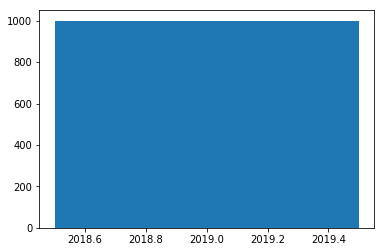

In [29]:
years = [k.year for k in tweets_df['created_at']]

plt.hist(years, bins = len(set(years)) )
plt.ticklabel_format(useOffset=False)

In [24]:
tweets_df.to_csv(OUTPUT_FILE, index=False)